# Task 1: Preprocess dataset

In [1]:
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, BertModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset, random_split
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm  # Import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import string
import torch


# File paths
train_file_path = 'data/train.jsonl'
test_file_path = 'data/test.jsonl'





d:\MachineLearning\python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Naive Bayes preprocess dataset

In [2]:
# Function to load data from jsonl file into a pandas DataFrame
def load_dataNB(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Load training and test data
train_dataNB = load_dataNB(train_file_path)
test_dataNB = load_dataNB(test_file_path)

# Preprocessing: Bag of Words representation using CountVectorizer
vectorizer = CountVectorizer()
X_train_NB = vectorizer.fit_transform(train_dataNB['text'])
y_train_NB = train_dataNB['label']
X_test_NB = vectorizer.transform(test_dataNB['text'])
y_test_NB = test_dataNB['label']


## BERT preprocess

In [4]:
# Function to load data from a JSONL file
def load_data_Bert(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

# Load data from the provided JSONL files
train_data_Bert = load_data_Bert(train_file_path)
test_data_Bert = load_data_Bert(test_file_path)

# Extract texts and labels for training and testing
X_train_Bert = [entry['text'] for entry in train_data_Bert]
y_train_Bert = [entry['label'] for entry in train_data_Bert]
X_test_Bert = [entry['text'] for entry in test_data_Bert]
y_test_Bert = [entry['label'] for entry in test_data_Bert]

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset class for handling the text data
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset_Bert = EmotionDataset(X_train_Bert, y_train_Bert, tokenizer)
test_dataset_Bert = EmotionDataset(X_test_Bert, y_test_Bert, tokenizer)

# Load pre-trained BERT model for sequence classification
model_Bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y_train_Bert)))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Task 2: Implement Naive Bayes and BERT models

## Naive Bayes

In [4]:

# Naive Bayes implementation
class NaiveBayes:
    def __init__(self):
        self.log_prior = None
        self.log_likelihood = None
        self.classes = None

    def fit(self, X, y):
        # Calculate the prior probabilities and likelihoods for each class
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]

        self.log_prior = np.log(np.array([np.sum(y == c) for c in self.classes]) / len(y))

        # Calculate likelihoods
        self.log_likelihood = np.zeros((n_classes, n_features))
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.log_likelihood[idx, :] = np.log((np.sum(X_c, axis=0) + 1) / (np.sum(X_c) + n_features))

    def predict(self, X):
        # Predict the class for each sample in X
        predictions = []        
        for x in X:
            log_prob = self.log_prior + x @ self.log_likelihood.T
            prediction = np.argmax(log_prob)
            predictions.append(self.classes[prediction])
        return np.array(predictions)

    def evaluate_accuracy(self, y_true, y_pred):
        # Calculate the accuracy of the predictions
        return np.mean(y_true == y_pred)
    



## BERT models

In [5]:
# Function to train and evaluate the model
def train_Bert_model(model, train_dataset, test_dataset, epochs=8, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    for epoch in range(epochs):
        model.train()
        # Wrap the train_loader with tqdm for a progress bar
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

    model.eval()
    predictions = []
    actuals = []

    # Wrap the test_loader with tqdm for a progress bar
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).tolist())
            actuals.extend(labels.tolist())

    # Calculate accuracy
    accuracy = accuracy_score(actuals, predictions)
    return accuracy, predictions


## BERT_Modified

In [6]:
# Modified train_eval_bert_model function to include epoch accuracy print
def train_Bert_model_Modified(model, train_dataset, test_dataset, batch_size, learning_rate, epochs=4):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
        
        # Evaluation per epoch
        model.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                predictions.extend(torch.argmax(logits, dim=1).tolist())
                actuals.extend(labels.tolist())

        accuracy = accuracy_score(actuals, predictions)
        print(f"Epoch {epoch + 1} Accuracy: {accuracy:.4f}")
    
    return accuracy

## BERT_Modified_Li

In [7]:
# Splitting train_dataset into train and validation
train_size = int(0.8 * len(train_dataset_Bert))
val_size = len(train_dataset_Bert) - train_size
train_dataset_Bert, val_dataset = random_split(train_dataset_Bert, [train_size, val_size])

# Model Modification
class BertClassifier(torch.nn.Module):
    def __init__(self, num_labels):
        super(BertClassifier, self).__init__()
        # self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert = BertModel.from_pretrained('bhadresh-savani/bert-base-uncased-emotion')
        self.dropout = torch.nn.Dropout(0.1)
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, num_labels)
        self.relu = torch.nn.ReLU()

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.pooler_output
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer

model_BertL = BertClassifier(len(set(y_train_Bert)))

# Training and Evaluation Function
def train_Bert_model_ModifiedL(model, train_dataset, val_dataset, test_dataset, epochs=3, batch_size=32):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=5e-5)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for epoch in range(epochs):
        # Training
        model.train()
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Validation
        model.eval()
        val_accuracy = []
        val_loss = []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = torch.nn.functional.cross_entropy(outputs, labels)
                predictions = torch.argmax(outputs, dim=1)
                accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())

                val_accuracy.append(accuracy)
                val_loss.append(loss.item())

        print(f"Validation Accuracy: {np.mean(val_accuracy)}")
        print(f"Validation Loss: {np.mean(val_loss)}")

    # Evaluation
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            logits = outputs
            predictions.extend(torch.argmax(logits, dim=1).tolist())
            actuals.extend(labels.tolist())

    accuracy = accuracy_score(actuals, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(actuals, predictions, average='weighted')
    return accuracy, precision, recall, f1


# Task 3: Run experiments

## 3.1: Compare and report the performance of the Naive Bayes, BERT-based models and modified BERT-based model.

In [8]:
# Create and train the Naive Bayes model
model_NB = NaiveBayes()
model_NB.fit(X_train_NB, y_train_NB)

# Predict on the test set
y_pred_NB = model_NB.predict(X_test_NB)

# Evaluate the model
accuracy_NB = model_NB.evaluate_accuracy(y_test_NB, y_pred_NB)

# Print the accuracy
print(f"Model Accuracy: {accuracy_NB}")

Model Accuracy: 0.7655


In [9]:
# Train and evaluate the model
# From https://huggingface.co/bhadresh-savani/bert-base-uncased-emotion
# The pre-trained model for BERT uses the weights for epochs=8, batch_size=64, learning_Rates=2e-5
accuracy_Bert, predictions_Bert = train_Bert_model(model_Bert, train_dataset_Bert, test_dataset_Bert)
print("Model Accuracy:", accuracy_Bert)

Evaluating: 100%|██████████| 32/32 [00:02<00:00, 14.48it/s]

Model Accuracy: 0.9235


In [20]:
accuracy_BertM= train_Bert_model_Modified(model_Bert, train_dataset_Bert, test_dataset_Bert, 
                                                              batch_size=48, learning_rate=1e-05, epochs=4)
print("Model Accuracy:", accuracy_BertM)

Training Epoch 1/4: 100%|██████████| 267/267 [00:31<00:00,  8.49it/s]


Epoch 1 Accuracy: 0.9240


Training Epoch 2/4: 100%|██████████| 267/267 [00:31<00:00,  8.49it/s]


Epoch 2 Accuracy: 0.9265


Training Epoch 3/4: 100%|██████████| 267/267 [00:31<00:00,  8.50it/s]


Epoch 3 Accuracy: 0.9260


Training Epoch 4/4: 100%|██████████| 267/267 [00:31<00:00,  8.49it/s]


Epoch 4 Accuracy: 0.9295
Model Accuracy: 0.9295


In [36]:
accuracy_BertL, precision, recall, f1 = train_Bert_model_ModifiedL(model_BertL, train_dataset_Bert, val_dataset, test_dataset_Bert)
print(f"Model Accuracy: {accuracy_BertL}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

d:\MachineLearning\python310\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validating: 100%|██████████| 100/100 [00:03<00:00, 28.85it/s]


Validation Accuracy: 0.941875
Validation Loss: 0.34244544396467974


Validating: 100%|██████████| 100/100 [00:03<00:00, 28.98it/s]


Validation Accuracy: 0.9453125
Validation Loss: 0.31530143864569254


Validating: 100%|██████████| 100/100 [00:03<00:00, 29.07it/s]


Validation Accuracy: 0.9453125
Validation Loss: 0.34762997000027096


Evaluating: 100%|██████████| 63/63 [00:02<00:00, 28.02it/s]

Model Accuracy: 0.933, Precision: 0.9321887749514493, Recall: 0.933, F1 Score: 0.9321605676260625


In [9]:
# BERT Configuration
config = BertConfig.from_pretrained('bhadresh-savani/bert-base-uncased-emotion',
                                    num_labels=len(set(y_train_Bert)),
                                    num_hidden_layers=10,  # Modify number of hidden layers
                                    num_attention_heads=8,  # Modify number of attention heads
                                    hidden_size=1024,  # Modify hidden size
                                    intermediate_size=2048,  # Modify size of intermediate layers
                                    hidden_act="relu",  # Modify activation function
                                    attention_probs_dropout_prob=0.1)  # Modify dropout rate

model = BertForSequenceClassification(config)

# Training function
def train_model(model, train_dataset, test_dataset, epochs=4, batch_size=32):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).tolist())
            actuals.extend(labels.tolist())

    accuracy = accuracy_score(actuals, predictions)
    return accuracy

# Train and evaluate the model
accuracy_Post = train_model(model, train_dataset_Bert, test_dataset_Bert)
print(f"Model Accuracy: {accuracy_Post }")

Evaluating: 100%|██████████| 63/63 [00:02<00:00, 30.88it/s]

Model Accuracy: 0.8825


In [11]:
# Creating a DataFrame
data = {
    "Model": ["Naive Bayes", "BERT-model", "Modified BERT-model", "Modified BERT-model_Li", "Modified Bert according to Post"],
    "Accuracy": [accuracy_NB, accuracy_Bert, accuracy_BertM, accuracy_BertL, accuracy_Post ]
}

singleTable = pd.DataFrame(data)
singleTable

,Model,Accuracy
0,Naive Bayes,0.7655
1,BERT-model,0.9235
2,Modified BERT-model,0.9295
3,Modified BERT-model_Li,0.9330
4,Modified Bert according to Post,0.8825


## 3.2 Examine the attention matrix

In [13]:
correctList = []
incorrectList = []

# Ensure test_labels is a list or convert it to a list
test_labels_list = list(y_test_Bert)

for i in range(len(test_labels_list)):
    if test_labels_list[i] == predictions_Bert[i]:
        if len(correctList) < 20:
            correctList.append(X_test_Bert[i])
    else:
        if len(incorrectList) < 12:
            incorrectList.append(X_test_Bert[i])

    if len(correctList) >= 20 and len(incorrectList) >= 12:
        break

# print("Correctly labeled list: ")
# print(*correctList, sep = "\n")
# print("\n")
# print("Incorrectly labeled list: ")
# print(*incorrectList, sep = "\n")

rotten so im not very ambitious right now
blog because i feel shitty
her separate from me because i don t ever want her to feel
my bouquet of red and yellow tulips under my arm feeling slightly more
a little vain when i did this one
into a shop anywhere where i do not feel uncomfortable
when at the end of a telephone call
i clung to a relationship with a boy who was in many ways
i completely hated things i d exercise my democratic right speak my mind
handed however i play billiards left handed naturally so me trying to play
i am in paradise kissing those sweet lips make me feel like i
this blog but sometimes i feel for my faithful readers
heart is tortured by what i have done
with myself that i did not foresee her frustrations earlier leading to the
he generous
i know who most of them are by now and am starting to


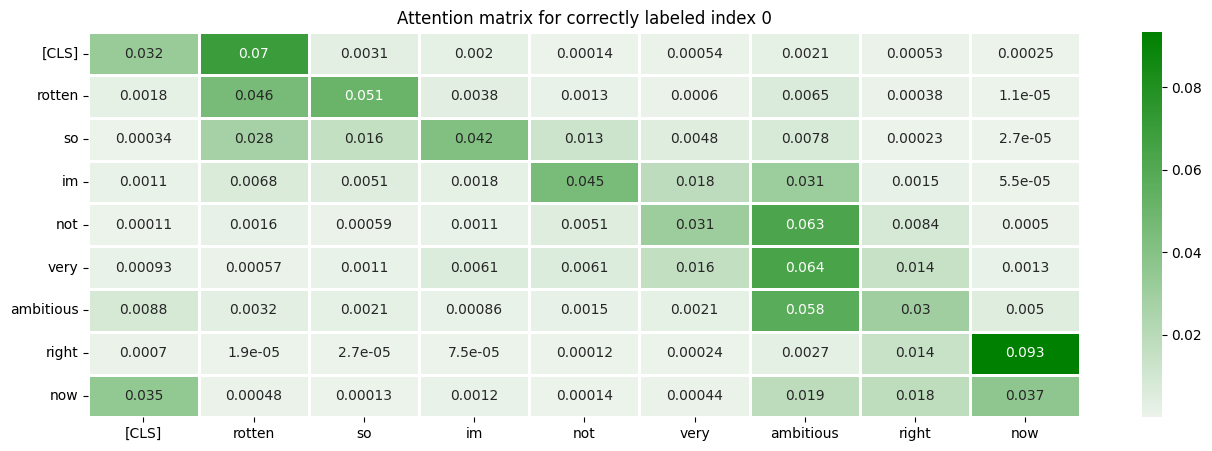

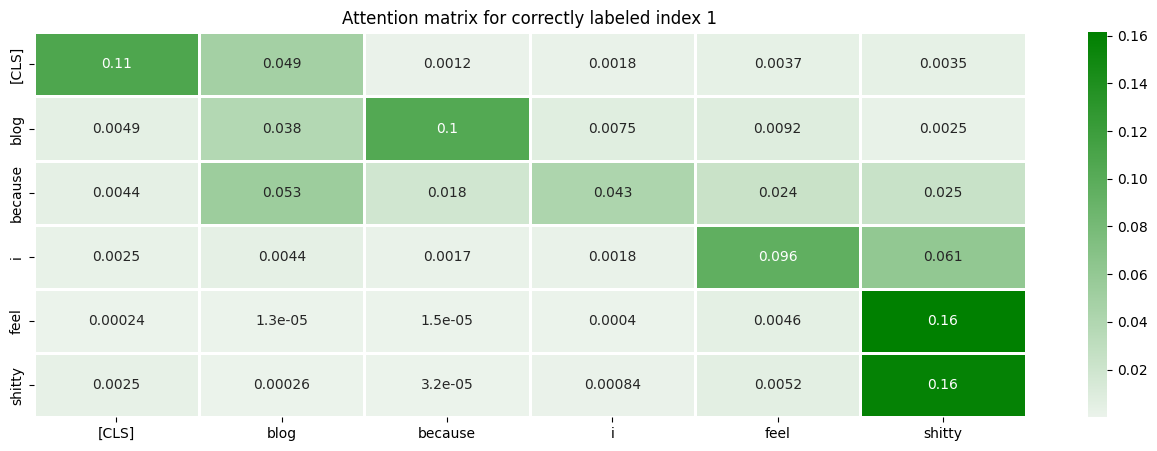

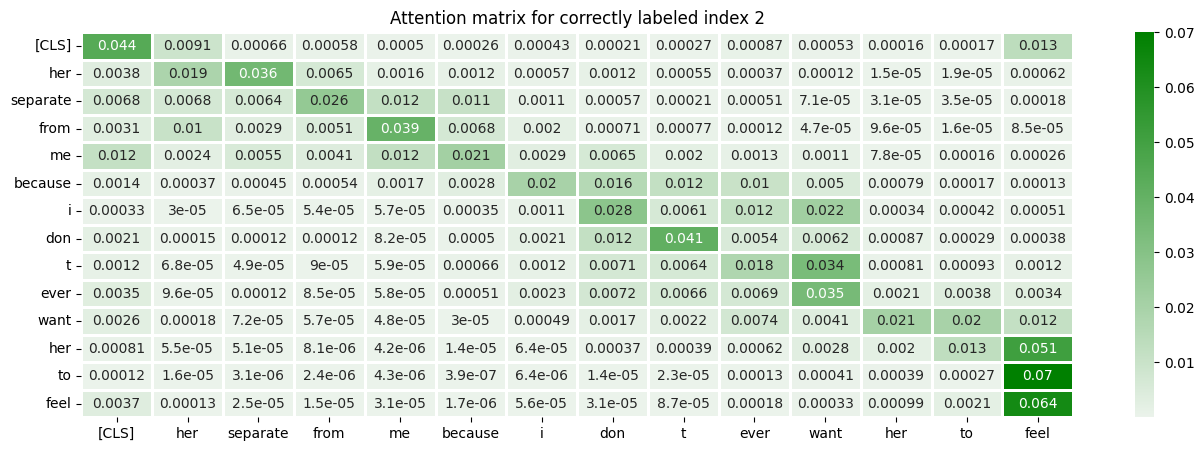

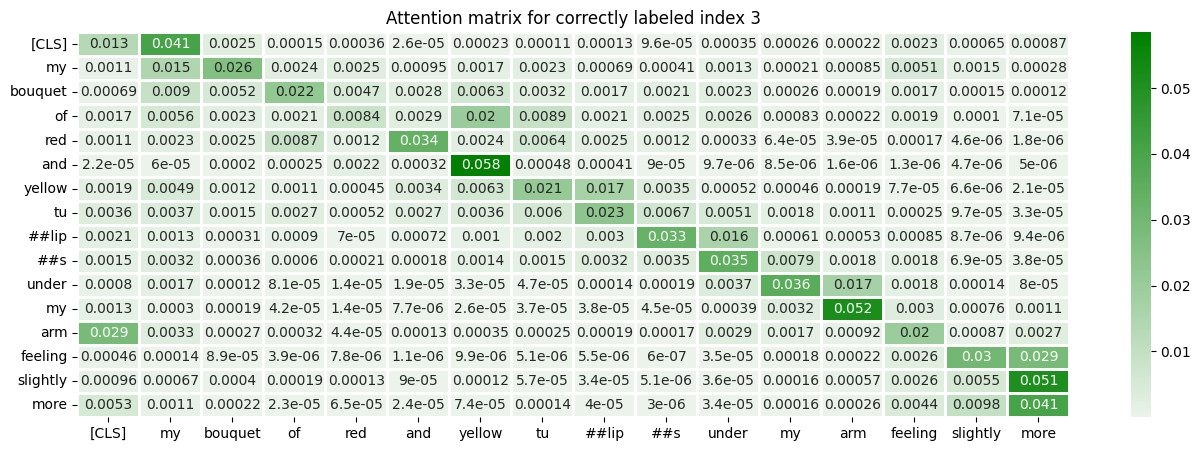

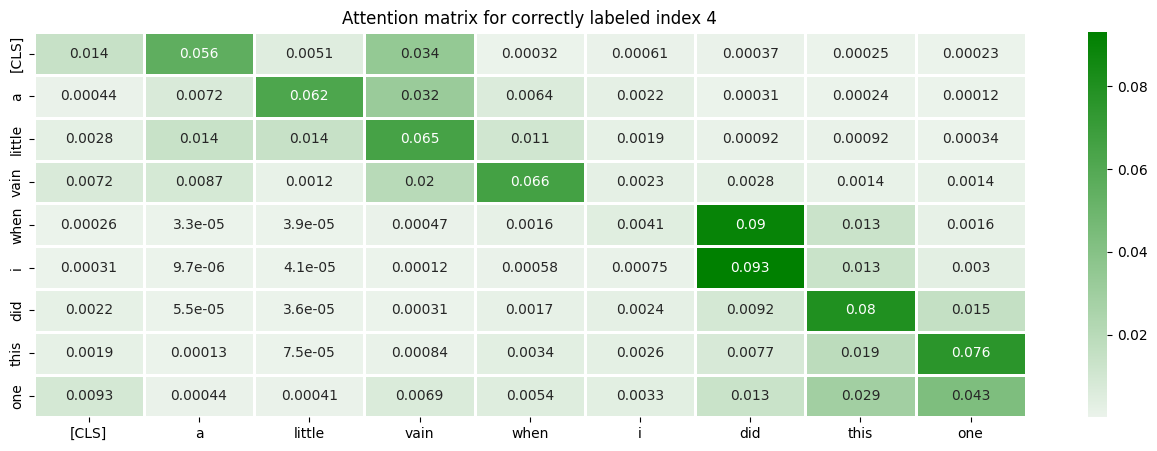

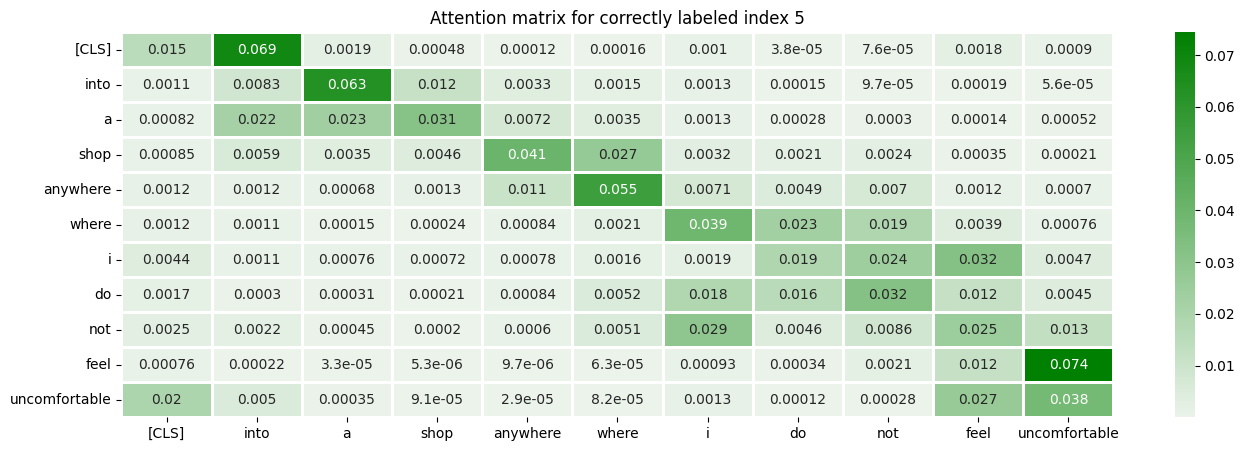

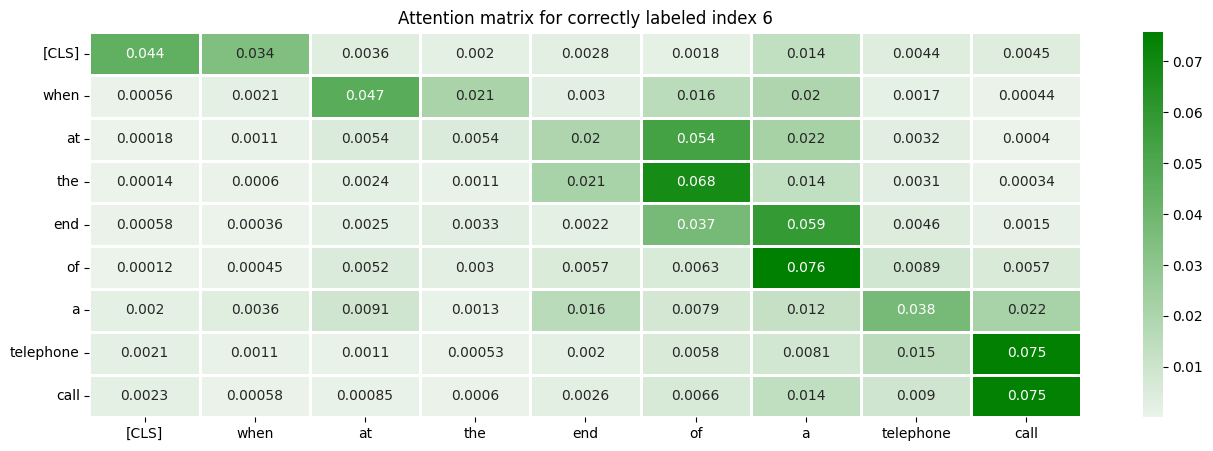

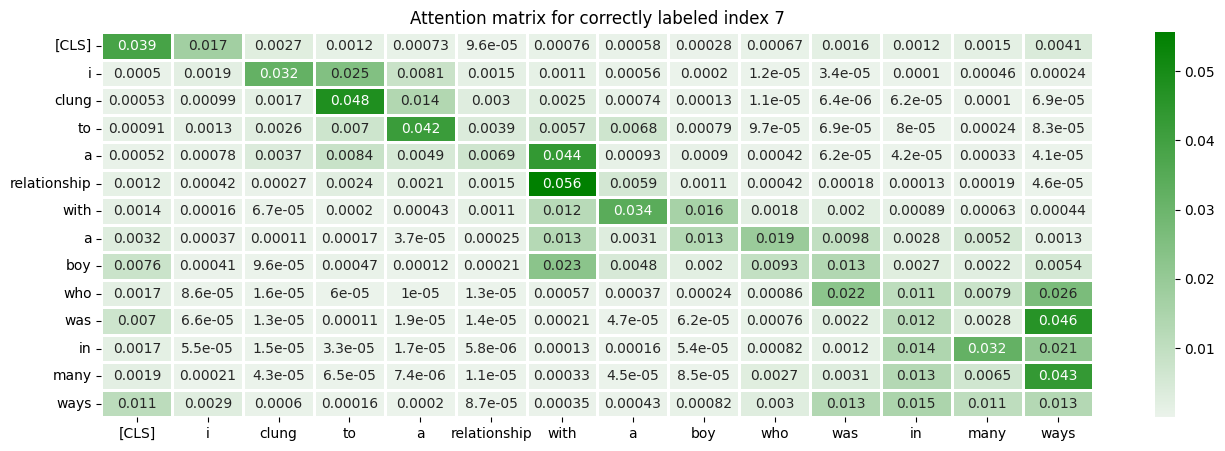

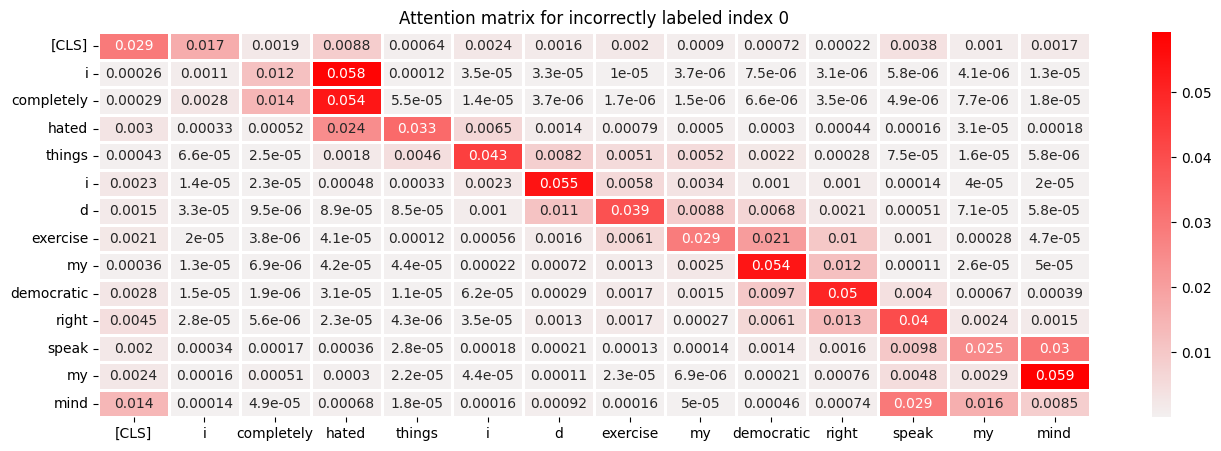

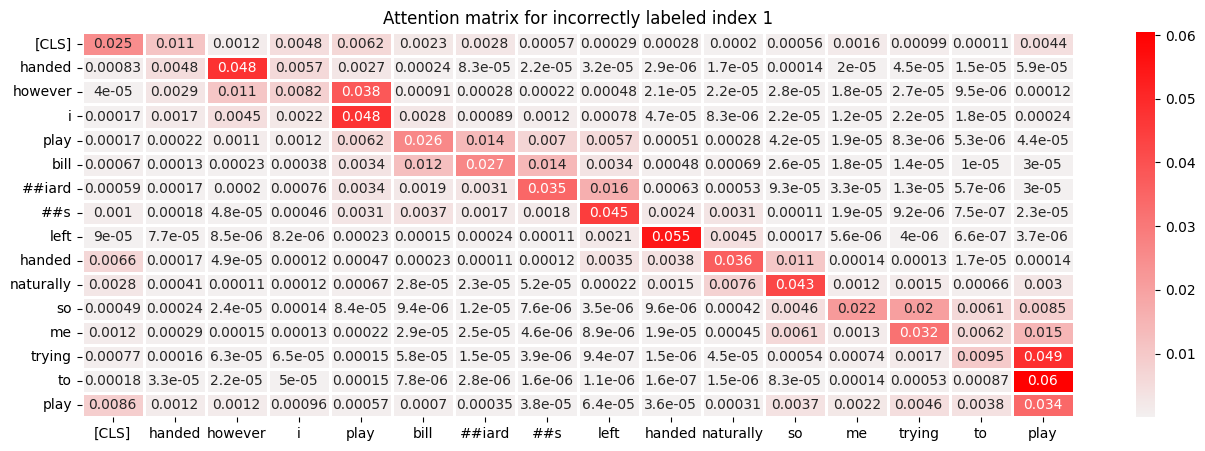

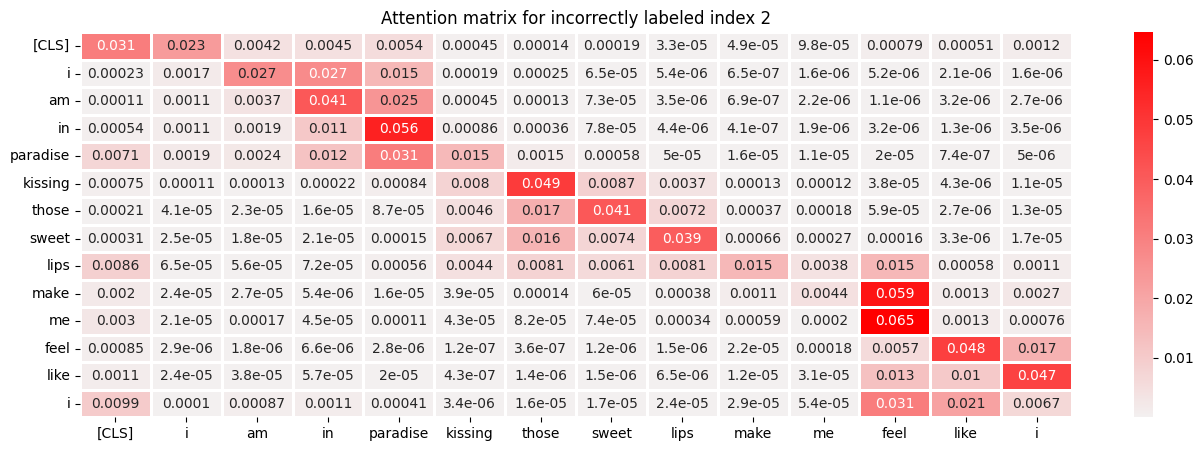

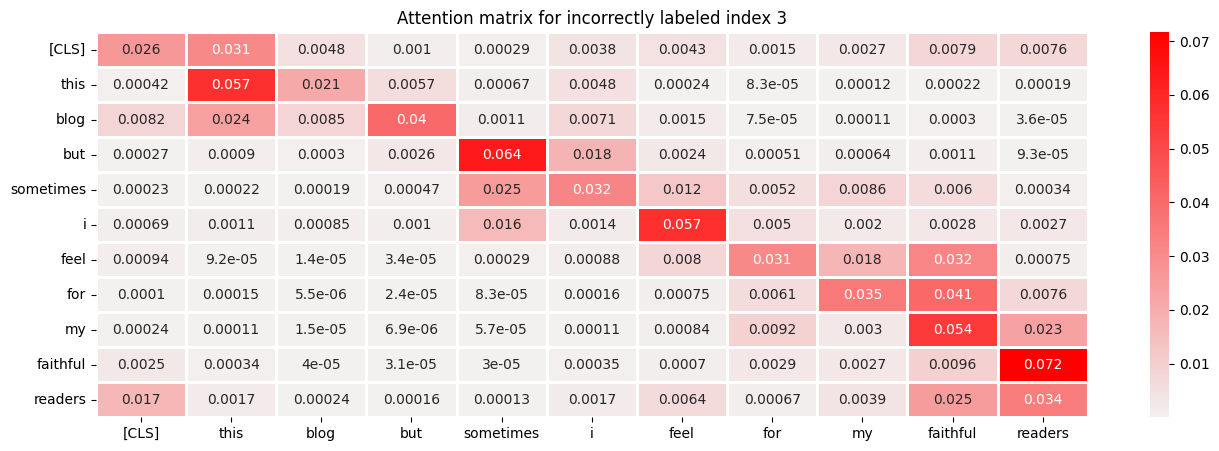

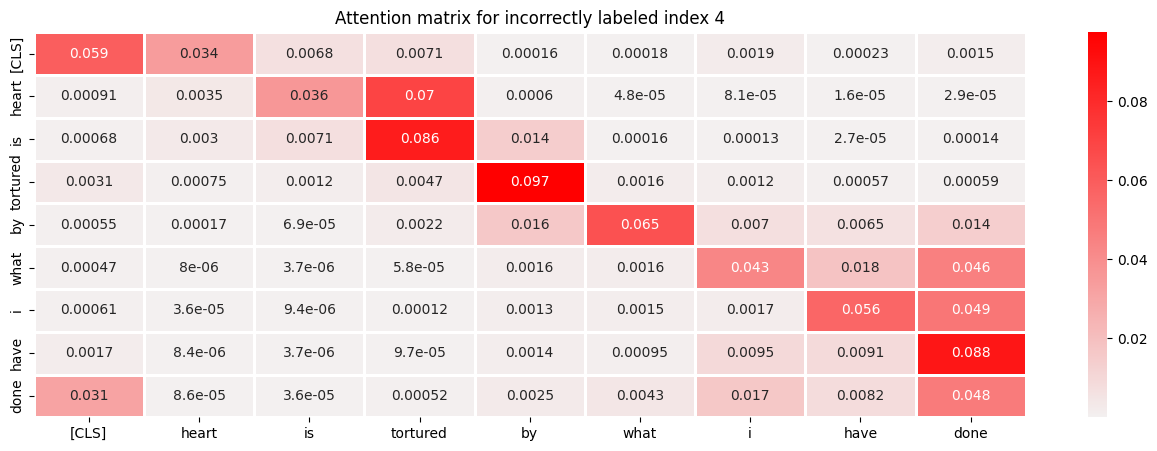

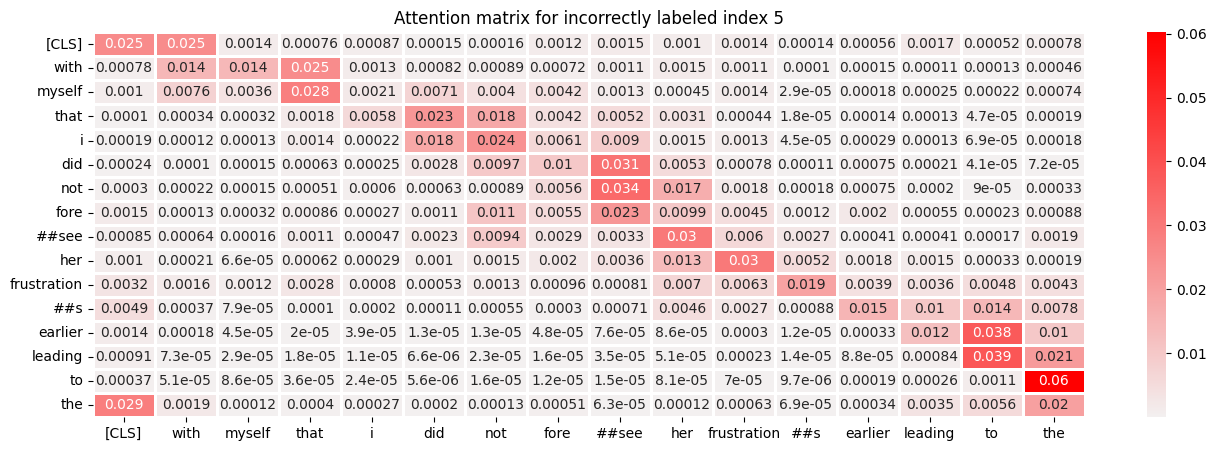

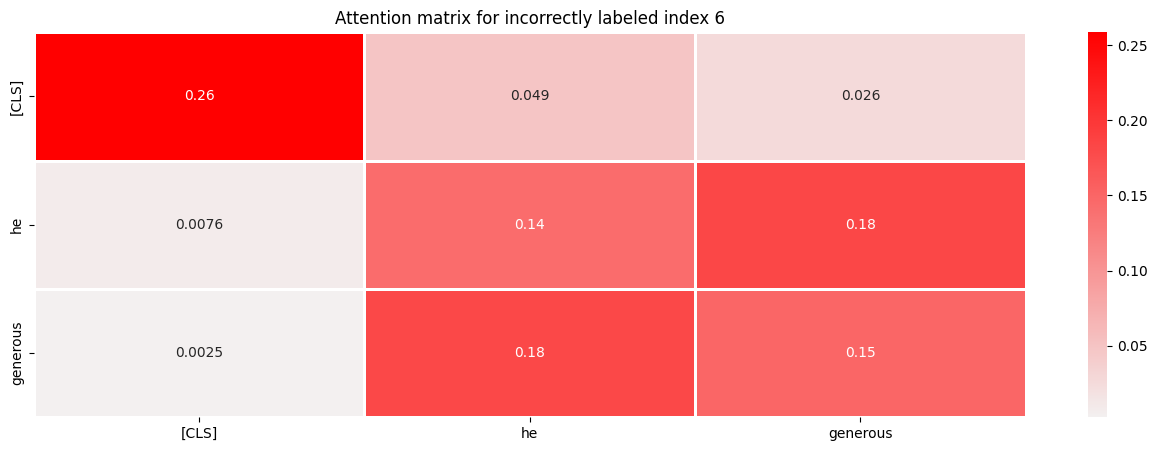

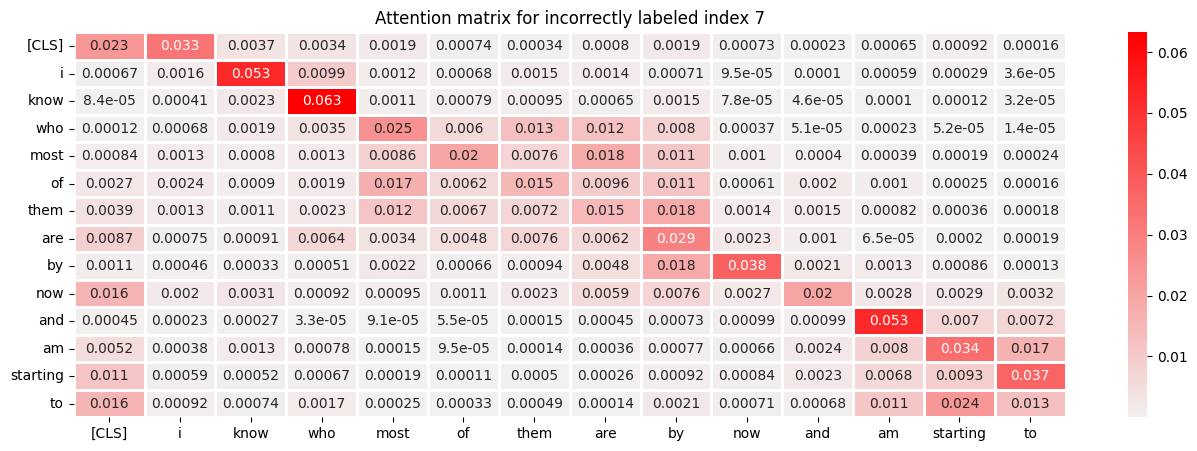

In [14]:
def split_sentence(sentence):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    words = sentence.split()
    ans = " ".join(words[3:16])
    return ans

def get_layer(layer, attention, shape):
  attention = attention[layer][0][layer].detach()/shape
  return attention

#chosen layer to generate attention matrix
layer = 6
def createAttentionMatrix(review, layer, color, index, correct=True):
    review = split_sentence(review)
    print(review)
    tk = [['[CLS]'] + tokenizer.tokenize(t)[:768] for t in [review]]
    tks = torch.tensor([tokenizer.convert_tokens_to_ids(tokens) for tokens in tk], dtype=torch.int)
    tks = torch.nn.utils.rnn.pad_sequence(tks, batch_first=True, padding_value=0)
    
    # Enable the output of attention weights
    model_output = model_Bert.cpu()(tks, output_attentions=True)
    attentionOutput = model_output.attentions

    att = get_layer(layer, attentionOutput, tks.shape[1])
    plt.figure(figsize=(16,5))
    heat = sns.heatmap(att, annot=True, cmap=sns.light_palette(color, as_cmap=True), linewidths=1, xticklabels=tk[0], yticklabels=tk[0])
    if correct:
        heat.set_title('Attention matrix for correctly labeled index ' + index)
    else:
        heat.set_title('Attention matrix for incorrectly labeled index ' + index)

# Visualization of Attention Matrices
for i, text in enumerate(correctList[:8]):
    createAttentionMatrix(text, layer, 'green', str(i), correct=True)


for i, text in enumerate(incorrectList[:8]):
    createAttentionMatrix(text, layer, 'red', str(i), correct=False)